In [1]:
import numpy as np
import pandas as pd

from plotnine import *
from sklearn.metrics import precision_recall_curve

In [2]:
n = 1000
m = 100

y_true = np.repeat([0, 1], n // 2)
y_scores = [np.random.permutation(np.linspace(0, 1, num=n)) for _ in range(m)]
y_scores_rigged = [np.concatenate((np.zeros(n // 10), np.random.permutation(np.linspace(0.1, 0.9, num=8 * n // 10)), np.ones(n // 10)))
                   for _ 
                   in range(m)]

curves = [precision_recall_curve(y_true, y_score) for y_score in y_scores]
curves_rigged = [precision_recall_curve(y_true, y_score) for y_score in y_scores_rigged]

In [3]:
grid = np.linspace(0, 1, num=50)

interps = [np.interp(x=grid, xp=r[::-1], fp=p)[::-1] for p, r, _ in curves]
interp_q = np.quantile(interps, q=0.9, axis=0)

interps_rigged = [np.interp(x=grid, xp=r[::-1], fp=p)[::-1] for p, r, _ in curves_rigged]
interp_rigged_q = np.quantile(interps_rigged, q=0.9, axis=0)

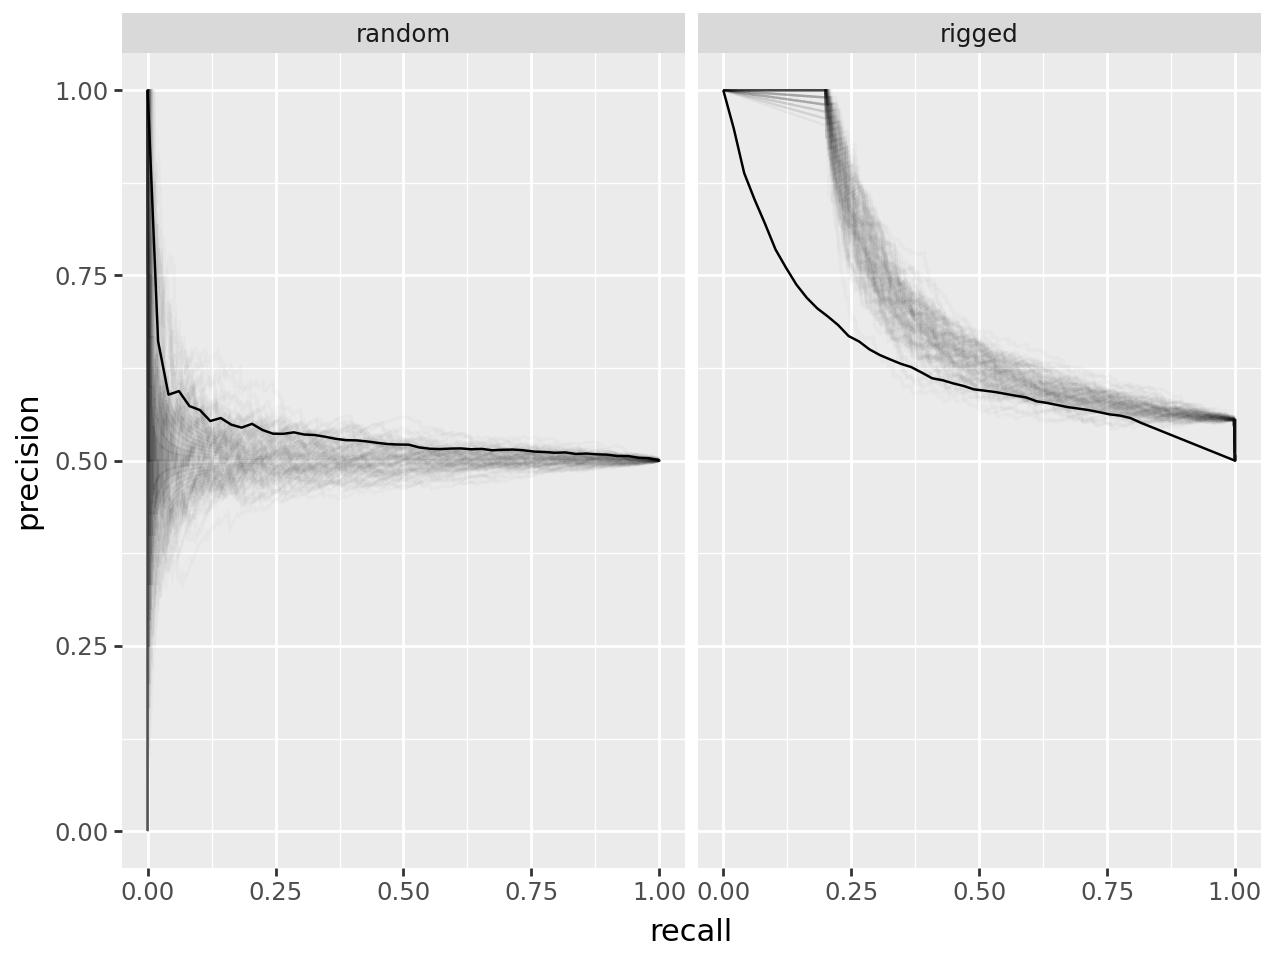

In [4]:
dfs = [pd.DataFrame({'precision': p, 'recall': r, 'group': i, 'model': 'random'}) for i, (p, r, _) in enumerate(curves)]
dfs += [pd.DataFrame({'precision': p, 'recall': r, 'group': i, 'model': 'rigged'}) for i, (p, r, _) in enumerate(curves_rigged)]
df_interp_q = pd.DataFrame({'grid': grid, 'interp': interp_q, 'model': 'random'})
df_interp_rigged_q = pd.DataFrame({'grid': grid, 'interp': interp_rigged_q, 'model': 'rigged'})

g = ggplot() + facet_wrap('model')
g = g + geom_line(aes('recall', 'precision', group='group'), data=pd.concat(dfs), alpha=2/m)
g = g + geom_line(aes('grid', 'interp'), data=pd.concat((df_interp_q, df_interp_rigged_q)))
g